# Synthetic Dataset Generation

In [1]:
import os
import numpy as np
import random
from sklearn.preprocessing import StandardScaler


MODEL_SAVE_PATH = "./model_save/"
datasets = ["synthetic", "synthetic_1"]

## Synthetic Dataset 0

### Description

The time series 

In [2]:
# settings
dataset = "synthetic"

dataset_length = 10000
anomaly_start = 5000
anomaly_end = 6000

In [9]:
for kpi_num in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    os.makedirs(f"./dataset/{dataset}/{kpi_num}", exist_ok=True)

    trains = []
    tests = []

    for i in range(kpi_num):
        sigma = random.uniform(0, 1)
        trains.append(np.sin(np.arange(dataset_length) / 100) + np.random.normal(0, 0.1, dataset_length))
        tests.append(np.sin(np.arange(dataset_length) / 100) + np.random.normal(0, 0.1, dataset_length))

    trains = np.array(trains).T
    tests = np.array(tests).T

    anomaly_value = 2.5

    # inject an anomaly to time series 0
    tests[anomaly_start:anomaly_end, 0] = anomaly_value

    labels = np.zeros((dataset_length,))
    labels[anomaly_start:anomaly_end] = 1
    
    scaler = StandardScaler()
    scaler.fit(trains)
    trains = scaler.transform(trains)
    tests = scaler.transform(tests)

    np.save(f"./dataset/{dataset}/{kpi_num}/train.npy", trains)
    np.save(f"./dataset/{dataset}/{kpi_num}/test.npy", tests)
    np.save(f"./dataset/{dataset}/{kpi_num}/labels.npy", labels)

In [25]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset):
    start = 3000
    end = 7000

    plt.figure()
    plt.subplot(3, 1, 1)
    plt.plot(np.arange(start, end), dataset[start:end, 0])
    plt.xticks([])
    plt.fill_between([5000,6000], -2, 4, alpha=0.5, color='yellow')
    plt.title("Time Series 0")
    plt.subplot(3, 1, 2)
    plt.plot(np.arange(start, end), dataset[start:end, 1])
    plt.xticks([])
    plt.fill_between([5000,6000], -2, 4, alpha=0.5, color='yellow')
    plt.title("Time Series 1")
    plt.subplot(3, 1, 3)
    plt.plot(np.arange(start, end), dataset[start:end, 2])
    plt.xticks([])
    plt.fill_between([5000,6000], -2, 4, alpha=0.5, color='yellow')
    plt.title("Time Series m-1")
    plt.subplots_adjust(hspace=0.3)

trains
tests


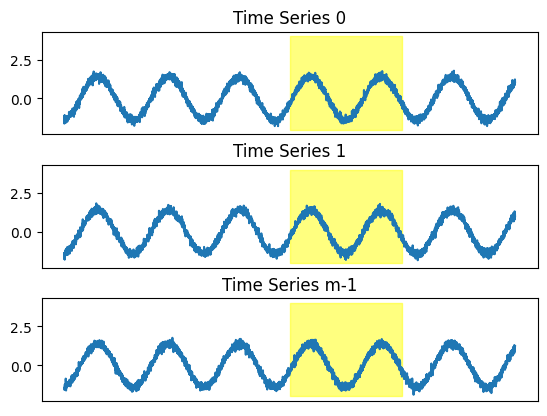

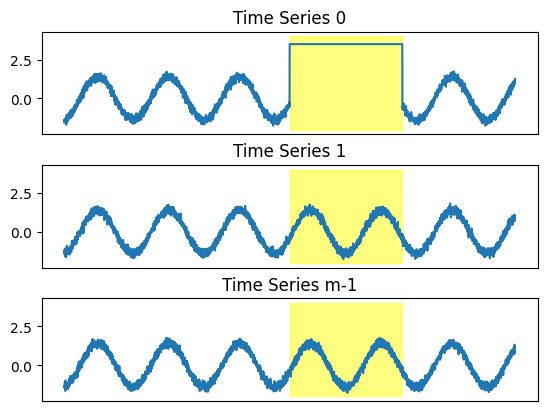

In [5]:
# visualize
print("trains")
visualize_dataset(trains)

print("tests")
visualize_dataset(tests)

## Synthetic Dataset 1

### Description



In [2]:
# settings
dataset = "synthetic_1"

dataset_length = 10000
anomaly_start = 5000
anomaly_end = 6000

In [23]:
kpi_num_set = [1, 2, 4, 8, 16, 32, 64, 128, 256]

cycles = np.random.randint(1, 500, size=kpi_num_set[-1])
noise_levels = np.random.uniform(0, 0.5, size=kpi_num_set[-1])

for kpi_num in kpi_num_set:
    os.makedirs(f"./dataset/{dataset}/{kpi_num}", exist_ok=True)

    trains = []
    tests = []

    for i in range(kpi_num):
        sigma = random.uniform(0, 1)
        trains.append(np.sin(np.arange(dataset_length) / cycles[i]) +
                      np.random.normal(0, noise_levels[i], dataset_length))
        tests.append(np.sin(np.arange(dataset_length) / cycles[i]) +
                     np.random.normal(0, noise_levels[i], dataset_length))

    trains = np.array(trains).T
    tests = np.array(tests).T

    anomaly_value = 2.5

    # inject an anomaly to time series 0
    tests[anomaly_start:anomaly_end, 0] = anomaly_value

    labels = np.zeros((dataset_length,))
    labels[anomaly_start:anomaly_end] = 1

    scaler = StandardScaler()
    scaler.fit(trains)
    trains = scaler.transform(trains)
    tests = scaler.transform(tests)

    np.save(f"./dataset/{dataset}/{kpi_num}/train.npy", trains)
    np.save(f"./dataset/{dataset}/{kpi_num}/test.npy", tests)
    np.save(f"./dataset/{dataset}/{kpi_num}/labels.npy", labels)

trains
tests


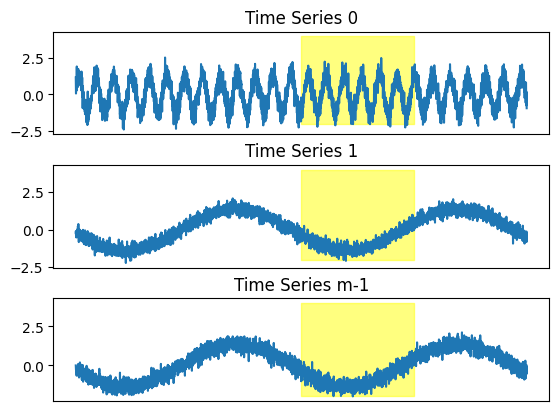

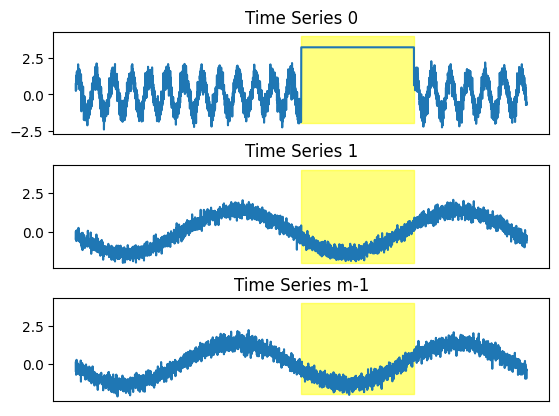

In [26]:
# visualize
print("trains")
visualize_dataset(trains)

print("tests")
visualize_dataset(tests)


# The Performance Loss of Anomaly Detection with Many KPIs

## AnomalyTransformer

In [3]:
import os
import time
import torch
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader


from anomaly_detection.data_factory.dataset import get_dataset_v2
from anomaly_detection.models.AnomalyTransformer import AnomalyTransformer
from anomaly_detection.solvers.solver import adjust_learning_rate, EarlyStopping
from anomaly_detection.data_factory.data_loader import SegLoader

kpi_nums = [2, 4, 8, 16, 32, 64, 128, 256]

win_size = 100
k = 3 # parameter
lr = 1e-4
patience = 3
batch_size = 256
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/xingjian/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

In [4]:
def my_kl_loss(p, q):
    res = p * (torch.log(p + 0.0001) - torch.log(q + 0.0001))
    return torch.mean(torch.sum(res, dim=-1), dim=1)


def calculate_validation_loss(model, data_loader):
    loss_1 = []
    loss_2 = []

    criterion = nn.MSELoss()
    for i, (input_data, _) in enumerate(data_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            series_loss += (torch.mean(my_kl_loss(series[u], (
                    prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach())) + torch.mean(
                my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)).detach(),
                    series[u])))
            prior_loss += (torch.mean(
                my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)),
                            series[u].detach())) + torch.mean(
                my_kl_loss(series[u].detach(),
                            (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)))))
        series_loss = series_loss / len(prior)
        prior_loss = prior_loss / len(prior)

        rec_loss = criterion(output, input)
        loss_1.append((rec_loss - k * series_loss).item())
        loss_2.append((rec_loss + k * prior_loss).item())

    return np.average(loss_1), np.average(loss_2)

dataset = 'synthetic_1'

for kpi_num in kpi_nums:
    print("kpi_num: ", kpi_num)
    input_c = kpi_num
    output_c = kpi_num

    data_path = f'./dataset/{dataset}/{kpi_num}'
    model_name = f'transformer_{dataset}_{kpi_num}'

    scaler_class = StandardScaler
    dataset_loader = get_dataset_v2(data_path, dataset, scaler_class,)

    train_loader = DataLoader(dataset= SegLoader(dataset_loader, win_size=win_size, step=1, mode="train"), 
                                        batch_size=batch_size, shuffle=True, num_workers=0)

    test_loader = DataLoader(dataset=SegLoader(dataset_loader, win_size=win_size, step=1, mode="test"),
                             batch_size=batch_size, shuffle=False, num_workers=0)

    criterion = nn.MSELoss()
    model = AnomalyTransformer(win_size=win_size, enc_in=input_c, c_out=output_c, e_layers=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    if torch.cuda.is_available():
        model.cuda()

    print("======================TRAIN MODE======================")

    time_now = time.time()
    if not os.path.exists(MODEL_SAVE_PATH):
        os.makedirs(MODEL_SAVE_PATH)
    early_stopping = EarlyStopping(patience=patience, verbose=True, checkpoint_name=model_name)
    train_steps = len(train_loader)

    for epoch in range(num_epochs):
        iter_count = 0
        loss1_list = []
        model.train()
        
        epoch_time = time.time()
        
        for i, (input_data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            iter_count += 1
            input = input_data.float().to(device)

            output, series, prior, _ = model(input)

            # calculate Association discrepancy
            series_loss = 0.0
            prior_loss = 0.0
            for u in range(len(prior)):
                series_loss += (torch.mean(my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)).detach())) + torch.mean(
                    my_kl_loss((prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                        win_size)).detach(),
                                series[u])))
                prior_loss += (torch.mean(my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach())) + torch.mean(
                    my_kl_loss(series[u].detach(), (
                            prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                    win_size)))))
            series_loss = series_loss / len(prior)
            prior_loss = prior_loss / len(prior)

            rec_loss = criterion(output, input)

            loss1_list.append((rec_loss - k * series_loss).item())
            loss1 = rec_loss - k * series_loss
            loss2 = rec_loss + k * prior_loss

            if (i + 1) % 100 == 0:
                speed = (time.time() - time_now) / iter_count
                left_time = speed * ((num_epochs - epoch) * train_steps - i)
                print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                iter_count = 0
                time_now = time.time()

            # Minimax strategy
            loss1.backward(retain_graph=True)
            loss2.backward()
            optimizer.step()

        print("Epoch: {} cost time: {}".format(epoch + 1, time.time() - epoch_time))
        train_loss = np.average(loss1_list)

        model.eval()
        vali_loss1, vali_loss2 = calculate_validation_loss(model, test_loader)

        print(
            "Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} ".format(
                epoch + 1, train_steps, train_loss, vali_loss1))
        early_stopping(vali_loss1, vali_loss2, model, MODEL_SAVE_PATH)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        torch.cuda.empty_cache()
        adjust_learning_rate(optimizer, epoch + 1, lr)

kpi_num:  2
(10000, 2)
======================TRAIN MODE======================
Epoch: 1 cost time: 9.35185194015503
Epoch: 1, Steps: 39 | Train Loss: -27.7009110 Vali Loss: -39.6565194 
Validation loss decreased (inf --> -39.656519).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 6.8522748947143555
Epoch: 2, Steps: 39 | Train Loss: -43.7115451 Vali Loss: -44.6008844 
EarlyStopping counter: 1 out of 3
Updating learning rate to 5e-05
Epoch: 3 cost time: 6.862623929977417
Epoch: 3, Steps: 39 | Train Loss: -44.9601762 Vali Loss: -44.9297230 
EarlyStopping counter: 2 out of 3
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 6.853105068206787
Epoch: 4, Steps: 39 | Train Loss: -45.2163172 Vali Loss: -45.0669067 
EarlyStopping counter: 3 out of 3
Early stopping
kpi_num:  4
(10000, 4)
======================TRAIN MODE======================
Epoch: 1 cost time: 6.855042219161987
Epoch: 1, Steps: 39 | Train Loss: -33.3212020 Vali Loss: -39.0947786 
Validation loss decrea

/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


======================TRAIN MODE======================
Epoch: 1 cost time: 6.979935169219971
Epoch: 1, Steps: 39 | Train Loss: nan Vali Loss: nan 
Validation loss decreased (inf --> nan).  Saving model ...
Updating learning rate to 0.0001
Epoch: 2 cost time: 7.002286195755005
Epoch: 2, Steps: 39 | Train Loss: nan Vali Loss: nan 
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 5e-05
Epoch: 3 cost time: 7.016260862350464
Epoch: 3, Steps: 39 | Train Loss: nan Vali Loss: nan 
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 2.5e-05
Epoch: 4 cost time: 7.005786180496216
Epoch: 4, Steps: 39 | Train Loss: nan Vali Loss: nan 
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 1.25e-05
Epoch: 5 cost time: 7.005664825439453
Epoch: 5, Steps: 39 | Train Loss: nan Vali Loss: nan 
Validation loss decreased (nan --> nan).  Saving model ...
Updating learning rate to 6.25e-06
Epoch: 6 cost time: 7

In [4]:
import torch
with torch.no_grad():
    torch.cuda.empty_cache()

### Model Testing

In [5]:
from anomaly_detection.solvers.solver import statistics_single_threshold_point_adjustment

def calculate_energy(criterion, temperature, data_loader, inspect_scores=False, result_path=None):
    if result_path is not None:
        os.makedirs(result_path, exist_ok=True)
    attens_energy = []

    if inspect_scores:
        reconstruction_loss_per_kpi = []
        attens_energy_per_kpi = []
        inputs = []
        outputs = []

    for i, (input_data, labels) in enumerate(data_loader):
        input = input_data.float().to(device)
        output, series, prior, _ = model(input)
        loss = torch.mean(criterion(input, output), dim=-1)
        series_loss = 0.0
        prior_loss = 0.0
        for u in range(len(prior)):
            if u == 0:
                series_loss = my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)).detach()) * temperature
                prior_loss = my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature
            else:
                series_loss += my_kl_loss(series[u], (
                        prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                                win_size)).detach()) * temperature
                prior_loss += my_kl_loss(
                    (prior[u] / torch.unsqueeze(torch.sum(prior[u], dim=-1), dim=-1).repeat(1, 1, 1,
                                                                                            win_size)),
                    series[u].detach()) * temperature

        metric = torch.softmax((-series_loss - prior_loss), dim=-1)
        cri = metric * loss
        cri = cri.detach().cpu().numpy()
        attens_energy.append(cri)

        if inspect_scores:
            loss_per_kpi = criterion(input, output)
            reconstruction_loss_per_kpi.append(loss_per_kpi.detach().cpu().numpy())
            cri_per_kpi = metric.unsqueeze(1) * loss_per_kpi.transpose(1, 2) # np.matmul(metric, loss_per_kpi, axes=([1], [1]))
            attens_energy_per_kpi.append(cri_per_kpi.detach().cpu().numpy())
            inputs.append(input.detach().cpu().numpy())
            outputs.append(output.detach().cpu().numpy())

        
    attens_energy = np.concatenate(attens_energy, axis=0).reshape(-1)

    if inspect_scores:
        reconstruction_loss_per_kpi = np.concatenate(reconstruction_loss_per_kpi, axis=0)
        reconstruction_loss_per_kpi = reconstruction_loss_per_kpi.reshape(-1, reconstruction_loss_per_kpi.shape[-1])
        attens_energy_per_kpi = np.concatenate(attens_energy_per_kpi, axis=0).transpose((0, 2, 1))
        attens_energy_per_kpi = attens_energy_per_kpi.reshape(-1, attens_energy_per_kpi.shape[-1])
        np.save(os.path.join(result_path, "reconstruction_loss_per_kpi.npy"), reconstruction_loss_per_kpi)
        np.save(os.path.join(result_path, "attens_energy_per_kpi.npy"), attens_energy_per_kpi)
        np.save(os.path.join(result_path, "attens_energy.npy"), attens_energy)

        inputs = np.concatenate(inputs, axis=0)
        outputs = np.concatenate(outputs, axis=0)
        print("input output shape:", inputs.shape, outputs.shape)
        np.save(os.path.join(result_path, "inputs.npy"), inputs)
        np.save(os.path.join(result_path, "outputs.npy"), outputs)
    return np.array(attens_energy)
    

In [6]:
dataset = 'synthetic_1'
anomaly_ratio = 0.2

for kpi_num in kpi_nums:
    print("kpi_num: ", kpi_num)
    data_path = f'./dataset/{dataset}/{kpi_num}'
    result_path = f'./output/{dataset}/{kpi_num}/'
    
    model_name = f'transformer_{dataset}_{kpi_num}'

    scaler_class = StandardScaler
    dataset_loader = get_dataset_v2(data_path, dataset, scaler_class,)

    train_loader = DataLoader(dataset= SegLoader(dataset_loader, win_size=win_size, step=1, mode="train"), 
                                        batch_size=batch_size, shuffle=True, num_workers=0)

    thre_loader = DataLoader(dataset= SegLoader(dataset_loader, win_size=win_size, step=1, mode="thre"), 
                                        batch_size=batch_size, shuffle=False, num_workers=0)
    
    model = AnomalyTransformer(win_size=win_size, enc_in=kpi_num, c_out=kpi_num, e_layers=3)
    model.load_state_dict(torch.load(f"./model_save/{model_name}_checkpoint.pth"))

    if torch.cuda.is_available():
        model.cuda()

    with torch.no_grad():
        model.eval()
        temperature = 50
        criterion = nn.MSELoss(reduction='none')

        # (1) stastic on the train set
        train_energy = calculate_energy(criterion, temperature, train_loader)

        # (2) find the threshold
        test_energy = calculate_energy(criterion, temperature, thre_loader)
        
        combined_energy = np.concatenate([train_energy, test_energy], axis=0)

        # (3) evaluation on the test set
        test_labels = []
        for i, (input_data, labels) in enumerate(thre_loader):
            test_labels.append(labels)
        test_labels = np.concatenate(test_labels, axis=0).reshape(-1)
        test_labels = np.array(test_labels)
        test_energy = calculate_energy(criterion, temperature, thre_loader, inspect_scores=True, result_path=os.path.join(result_path, "reconstruction"))

        thresh = np.percentile(test_energy, 100 - anomaly_ratio)
        pred, accuracy, f1_data, anomaly_event_hit = statistics_single_threshold_point_adjustment(test_energy, thresh, test_labels)


        # calculate precision with label and pred
        print(pred.shape, test_labels.shape)
        precision = np.logical_and(pred, test_labels).sum() / pred.sum()
        
        os.makedirs(result_path, exist_ok=True)
        np.save(os.path.join(result_path, "pred.npy"), pred)
        np.save(os.path.join(result_path, "score.npy"), test_energy)
        print("anomaly_ratio:", anomaly_ratio, "threshold:", thresh, "accuracy:", accuracy, "precision:", precision)
        print(f1_data)


kpi_num:  2
(10000, 2)
input output shape: (100, 100, 2) (100, 100, 2)
(10000,) (10000,)
anomaly_ratio: 0.2 threshold: 0.1664722281992539 accuracy: 0.9991 precision: 0.55
   precision  recall       f1
0    0.99108     1.0  0.99552
kpi_num:  4
(10000, 4)
input output shape: (100, 100, 4) (100, 100, 4)
(10000,) (10000,)
anomaly_ratio: 0.2 threshold: 0.5634999837875548 accuracy: 0.898 precision: 0.0
   precision  recall   f1
0        0.0     0.0  0.0
kpi_num:  8
(10000, 8)
input output shape: (100, 100, 8) (100, 100, 8)
(10000,) (10000,)
anomaly_ratio: 0.2 threshold: 0.43040913611650605 accuracy: 0.898 precision: 0.0
   precision  recall   f1
0        0.0     0.0  0.0
kpi_num:  16
(10000, 16)
input output shape: (100, 100, 16) (100, 100, 16)
(10000,) (10000,)
anomaly_ratio: 0.2 threshold: 0.2380135228037839 accuracy: 0.9981 precision: 0.05
   precision  recall        f1
0   0.981354     1.0  0.990589
kpi_num:  32
(10000, 32)
input output shape: (100, 100, 32) (100, 100, 32)
(10000,) (1000

/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/home/xingjian/.local/lib/python3.10/site-packages/sklearn/utils/extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


input output shape: (100, 100, 256) (100, 100, 256)
(10000,) (10000,)
anomaly_ratio: 0.2 threshold: nan accuracy: 0.9 precision: nan
   precision  recall   f1
0        0.0     0.0  0.0


/home/xingjian/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_420948/2936115797.py:53: RuntimeWarning: invalid value encountered in scalar divide
  precision = np.logical_and(pred, test_labels).sum() / pred.sum()


### Visualize

#### Reconstruction

In [ ]:
def load_output_data(dataset, kpi_num):
    reconstruction_result_path = f'./output/{dataset}/{kpi_num}/reconstruction/'
    
    input_data = np.load(os.path.join(reconstruction_result_path, "inputs.npy"))
    input_data = input_data.reshape(-1, input_data.shape[-1])
    output_data = np.load(os.path.join(reconstruction_result_path, "outputs.npy"))
    output_data = output_data.reshape(-1, output_data.shape[-1])
    reconstruction_loss_per_kpi = np.load(os.path.join(
        reconstruction_result_path, "reconstruction_loss_per_kpi.npy"))
    attens_energy_per_kpi = np.load(os.path.join(
        reconstruction_result_path, "attens_energy_per_kpi.npy"))
    attens_energy = np.load(os.path.join(
        reconstruction_result_path, "attens_energy.npy"))
    
    return input_data, output_data, reconstruction_loss_per_kpi, attens_energy_per_kpi, attens_energy

In [8]:
dataset = "synthetic_1"
kpi_num = 2

input_data, output_data, reconstruction_loss_per_kpi, attens_energy_per_kpi, attens_energy = load_output_data(dataset, kpi_num)

In [9]:
print(input_data.shape)
print(output_data.shape)
print(reconstruction_loss_per_kpi.shape)
print(attens_energy_per_kpi.shape)
print(attens_energy.shape)

(10000, 2)
(10000, 2)
(10000, 2)
(10000, 2)
(10000,)


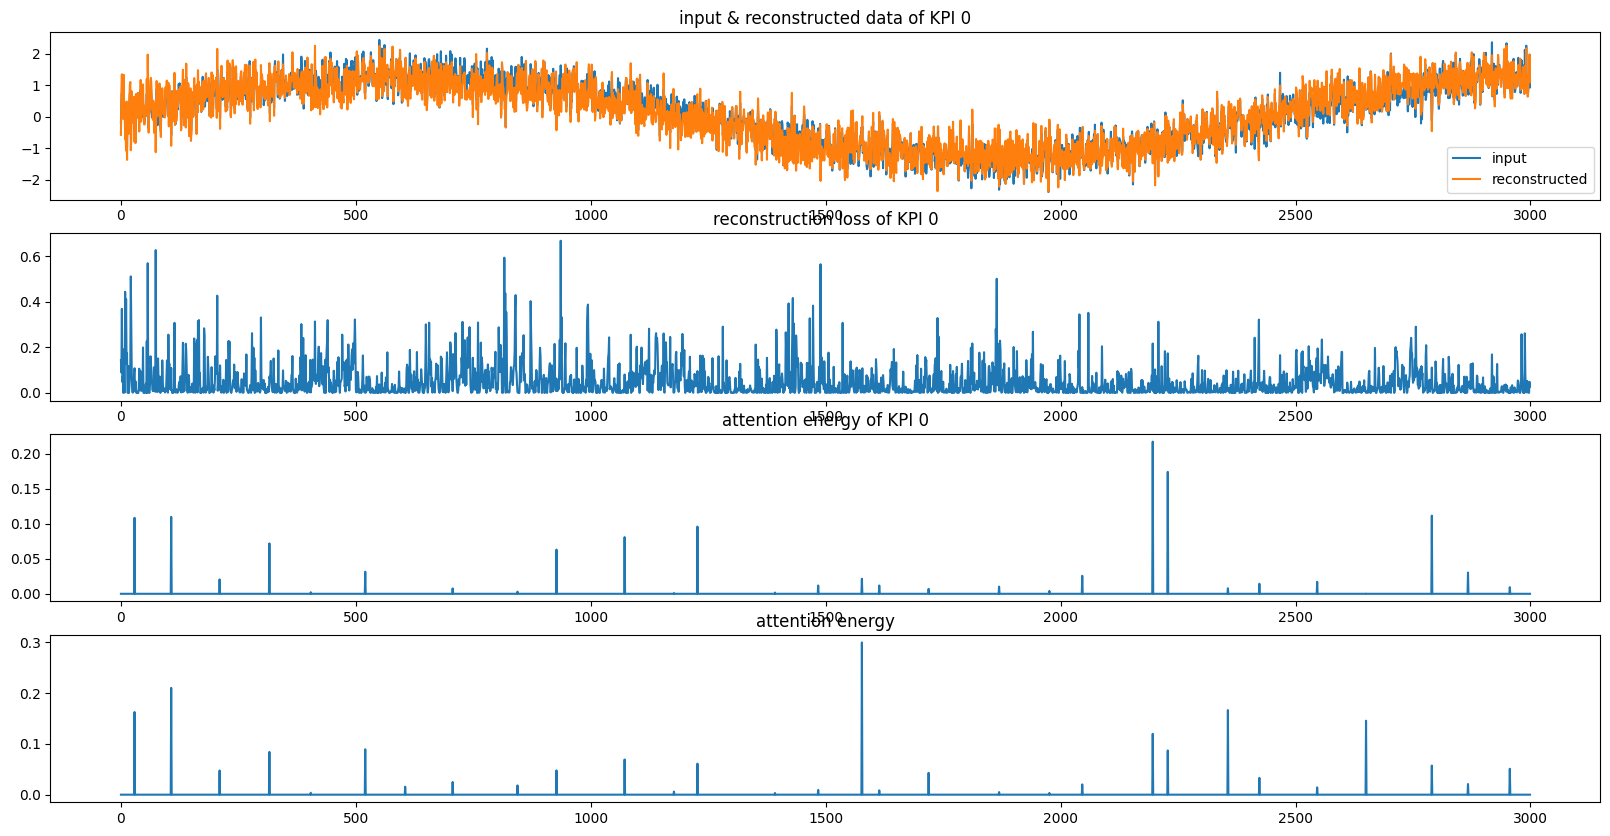

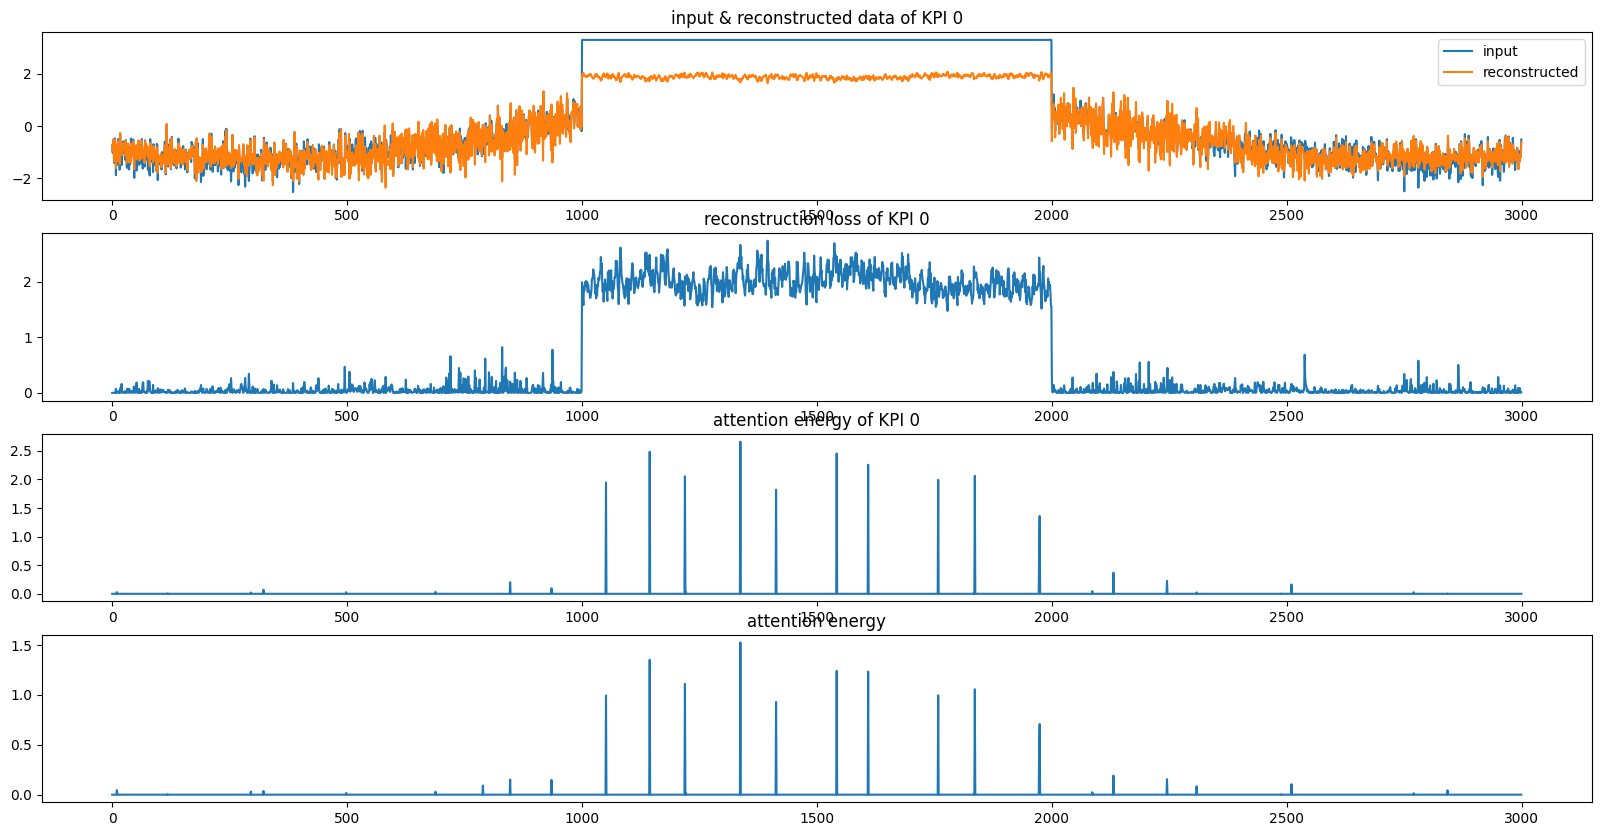

In [17]:
import matplotlib.pyplot as plt

def plot_values(start, end):
    plt.figure(figsize=(20, 10))
    plt.subplot(4, 1, 1)
    plt.plot(input_data[start:end, 0], label="input")
    plt.plot(output_data[start:end, 0], label="reconstructed")
    plt.title("reconstructed data")
    plt.legend()
    plt.title("input & reconstructed data of KPI 0")

    plt.subplot(4, 1, 2)

    plt.plot(reconstruction_loss_per_kpi[start:end, 0], label="reconstruction loss")
    plt.title("reconstruction loss of KPI 0")
    

    plt.subplot(4, 1, 3)

    plt.plot(attens_energy_per_kpi[start:end, 0], label="attention energy")
    plt.title("attention energy of KPI 0")

    plt.subplot(4, 1, 4)
    plt.plot(attens_energy[start:end])
    plt.title("attention energy")

# Normal State

plot_values(0, 3000)

# Anomaly State

plot_values(anomaly_start - 1000, anomaly_end + 1000)

Text(0.5, 1.0, 'Reconstruction Losses')

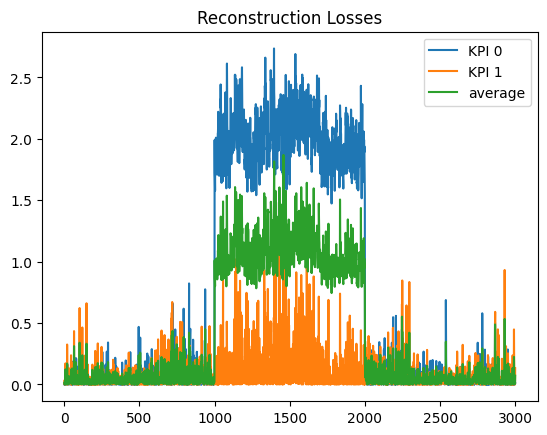

In [16]:
padding = 1000
start = anomaly_start - padding 
end = anomaly_end + padding
for i in range(0, kpi_num):
    plt.plot(reconstruction_loss_per_kpi[start:end, i], label=f"KPI {i}")

reconstruction_loss_avg = np.mean(reconstruction_loss_per_kpi, axis=1)
plt.plot(reconstruction_loss_avg[start:end], label="average")

plt.legend()

plt.title("Reconstruction Losses")

#### Anomaly Score

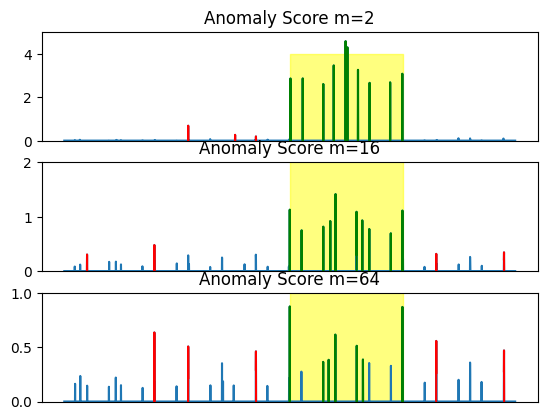

In [22]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

start = 3000
end = 7000


dataset = "synthetic"
test_data = np.load(f"./dataset/{dataset}/1/test.npy")
test_label = np.load(f"./dataset/{dataset}/1/labels.npy")

def plot_score(score, pred, test_labels, kpi_start, kpi_end, anomaly_start, anomaly_end):
    # anomaly score
    plt.plot(np.arange(start, end), score[start:end])

    # anomaly period
    plt.fill_between([anomaly_start, anomaly_end], 0, 4, alpha=0.5, color='yellow')

    # prediction result
    for i in range(start, end):
        if pred[i] == 1:
            if test_labels[i] == 1:
                plt.plot([i-1, i, i+1], score[i-1:i+2], color='green')
                # plt.axvline(i, color='red')
            else:
                plt.plot([i-1, i, i+1], score[i-1:i+2], color='red')
    
    plt.ylim(0, np.ceil(np.max(score)))
    plt.xticks([])


kpi_num_plot_set = [2, 16, 64]

for i, kpi_num in enumerate(kpi_num_plot_set):
    plt.subplot(len(kpi_num_plot_set), 1, i+1)
    result_path = f'./output/{dataset}/{kpi_num}/'

    pred = np.load(os.path.join(result_path, "pred.npy"))
    score = np.load(os.path.join(result_path, "score.npy"))

    plot_score(score, pred, test_labels, start, end, anomaly_start=anomaly_start, anomaly_end=anomaly_end)

    
    plt.title(f"Anomaly Score m={kpi_num}")


# fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))

# plt.subplot(3, 1, 1)


# plt.plot(np.arange(start, end), test_data[start:end, 0])
# plt.xticks([])

# plt.fill_between([anomaly_start, anomaly_end], -2, 4, alpha=0.5, color='yellow')

# plt.title("Time Series 0")

# custom_legend = [
#     Line2D([0], [0], color='green', linestyle='-', lw=2),
#     Line2D([0], [0], color='red', linestyle='-', lw=2),
#     Rectangle((0, 0), 1, 1, fc="yellow", alpha=0.5)
# ]

# plt.legend(custom_legend, ['True Positive',
#            'False Positive', 'Anomaly'], loc='upper right')

# plt.subplot(3, 1, 2)

# kpi_num = 2

# result_path = f'./output/{dataset}/{kpi_num}/'

# pred = np.load(os.path.join(result_path, "pred.npy"))
# score = np.load(os.path.join(result_path, "score.npy"))
# print(pred.shape)

# plot_score(score, pred, test_labels, start, end, anomaly_start=anomaly_start, anomaly_end=anomaly_end)

# plt.title(f"Anomaly Score m={kpi_num}")

# plt.subplot(3, 1, 3)

# kpi_num = 64

# result_path = f'./output/{dataset}/{kpi_num}/'

# pred = np.load(os.path.join(result_path, "pred.npy"))
# score = np.load(os.path.join(result_path, "score.npy"))
# plot_score(score, pred, test_labels, start, end, anomaly_start=anomaly_start, anomaly_end=anomaly_end)

# plt.title(f"Anomaly Score m={kpi_num}")

## USAD

### Model Training

In [9]:
from anomaly_detection.solvers import UsadSolver, AnomalyTransformerSolver
from anomaly_detection.utils import get_default_device
from anomaly_detection.cluster import generate_feature_latents

kpi_num = 2

config = {
    'lr': 1e-4,
    'num_epochs': 10,
    'k': 3,
    'win_size': 100,
    'input_c': kpi_num,
    'output_c': kpi_num,
    'batch_size': 1024,
    'pretrained_model': None,
    'dataset': 'special',
    'mode': 'train',
    'data_path': f'./dataset/special/{kpi_num}',
    'model_save_path': 'checkpoints',
    'anomaly_ratio': 4.00,
    'output_dir': f'./output/special/{kpi_num}',
    'output_file': f'./output/special/{kpi_num}/output.txt',
    'event_output_file': f'./output/special/{kpi_num}/event_output.txt',
    'model_name': f'usad_special_{kpi_num}',
    'model_init_checkpoint': None,
    'hidden_size': 20,
    'model_type': 'usad',
    'multiple_anomaly_ratios': False,
    'subset_num': None,
    'patience': 3,
    'inspect_scores': True,
    'save_input_output': True,
    'scaler': 'standard',
    'log_step': 100,
    'score_method': 'mse',
    'select_file': None,
}

solver = UsadSolver(config)

solver.train()
solver.save_train_input_output()

config:  {'lr': 0.0001, 'num_epochs': 10, 'k': 3, 'win_size': 100, 'input_c': 2, 'output_c': 2, 'batch_size': 1024, 'pretrained_model': None, 'dataset': 'special', 'mode': 'train', 'data_path': './dataset/special/2', 'model_save_path': 'checkpoints', 'anomaly_ratio': 4.0, 'output_dir': './output/special/2', 'output_file': './output/special/2/output.txt', 'event_output_file': './output/special/2/event_output.txt', 'model_name': 'usad_special_2', 'model_init_checkpoint': None, 'hidden_size': 20, 'model_type': 'usad', 'multiple_anomaly_ratios': False, 'subset_num': None, 'patience': 3, 'inspect_scores': True, 'save_input_output': True, 'scaler': 'standard', 'log_step': 100, 'score_method': 'mse', 'select_file': None}
(10000, 2)
w_size:  200 z_size:  2000
UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=200, out_features=100, bias=True)
    (linear2): Linear(in_features=100, out_features=50, bias=True)
    (linear3): Linear(in_features=50, out_features=2000, bias=True)
  

AttributeError: 'UsadSolver' object has no attribute 'save_train_input_output'

## Model Testing